# Hands-on 01: Online retail - Cohort Analysis

## Concepts


One key go-to idea to uncover customer behavior is to spliting them into smaller groups that within each group they are more similar to each other.
That make the insights is cleared, comparing to doing analysis on the whole population. 

You will notice that they have done it by multiple ways in our analytics works: splitting customers by geo, app, level of values, etc.
In this hands-on, we try 3 techniques, serving that purpose: 

1. Cohort 
2. RFM segmentation 
3. KMeans clustering

We start with **Cohort analysis**, we commonly segment customers by the date they onboard with the app/products, 
with the assumption that each snapshot of time, we acquire a group of customers (as a cohort). 
The product offerings and marketing strategies are the same, so we expect customers in the same cohort are more or less comparable. 

In fact, cohorts is not necessarily defined as the time of acquiring customers, but other given factors that make the group of customers more similar.
The cohort by the starting time of customers give a view of how the product evolve over time, and how the customer base shift over time.


### What's cohort?
- *A cohort*: Individuals have some common in characteristics 
	- For example, users acquired through a same marketing campaign at the same date
	- First batch of students of an online course
- Cohort analysis is a useful way to compare groups of entities over time
	- Provide a framework to **detect correlations between cohort characteristics and long-term trends** -> Hypotheses about the causal drivers.
	- Compare new cohorts of customers and compare to previous cohorts -> Alerts when something has gone wrong


### Components of Cohort Analysis

Cohort analyses have three components

1. `Cohort grouping`: often based on the start date (customer's first purchase, subscription date, the date a student started school, etc.)
2. Time series of data over which a cohort is observed: 
    - A series of purchases, logins, interactions, Active Time Spent day-by-day after the start date
    - A series should cover the the entire life span (mature) 
    - A series should be long enough to complete the action of interest -> For example, if customers tend to purchase once a month, a time series of several months is needed. If, on the other hand, purchases happen only once a year, a time series of several years would be preferable.
    - Period is relative to the start date (for example, day0, day1, day2, etc.)
3. Aggregate metrics that we want to measures: Retention, Revenue along the life-cycle. Any metrics that matters to the health of the business -> Aggregate `sum`, `count`, `average`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns 
import pandas as pd 
import missingno
import openpyxl
import datetime as dt

In [2]:
# OPTIONA:
import warnings
warnings.filterwarnings('ignore')

Structure:
Load data -> Data Explore -> Clearning Data -> Prepare the data for Cohort Analysis (I) -> Cohort analysis
Note (I):
Step 1: Invoice_period
Step 2: Cohort_group
Step 3: Aggregate Metric
Step 4: Cohort_period

## Load Data

In [10]:
# TODO_01
df = pd.read_excel('data/Online Retail.xlsx', dtype={'CustomerID': str})
#dtype is a param to convert column CustomerID into str (before: float64)

In [11]:
print(df.dtypes)

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object


In [13]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [14]:
# TODO_02: Create order_value = Quantity x UnitPrice
df['order_value'] = df['Quantity']*df['UnitPrice']

In [15]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_value
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


## Data Explore

In [42]:
df.info()
#Have the first understanding about the dataframe, null or non-null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
 8   order_value  541909 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 37.2+ MB


In [43]:
df.describe().T
#Get overview about dataset 

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
order_value,541909.0,17.987795,378.810824,-168469.60,3.40,9.75,17.40,168469.6


In [44]:
df.describe(percentiles = [0.05,0.25,0.95]).T

,count,mean,std,min,5%,25%,50%,95%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,1.00,3.00,29.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,0.42,1.25,2.08,9.95,38970.0
order_value,541909.0,17.987795,378.810824,-168469.60,0.83,3.40,9.75,59.40,168469.6


In [62]:
# TODO_03: Using missingno to explore the missing values of datasets
miss_value = df.isna().sum()
# miss_value
df.replace('', np.NaN)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_value
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60


In [63]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
order_value         0
dtype: int64

<AxesSubplot:>

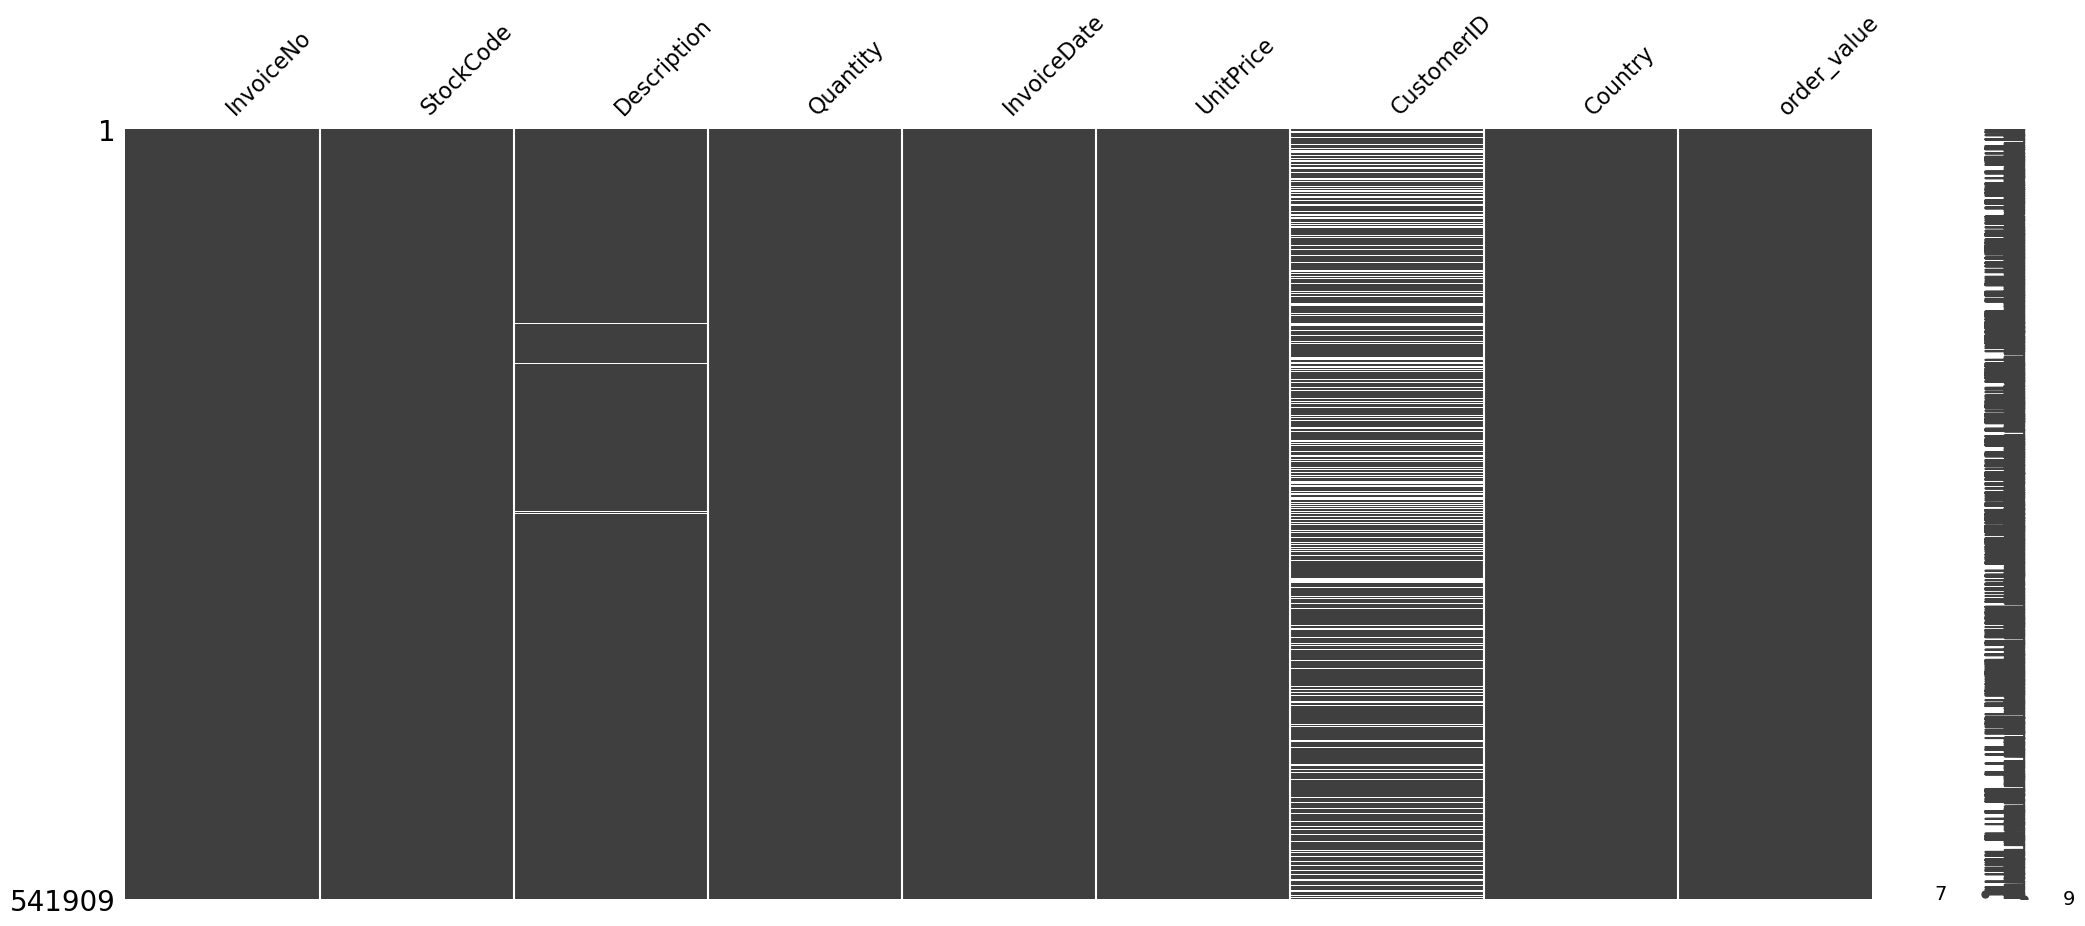

In [64]:
missingno.matrix(df)

<AxesSubplot:>

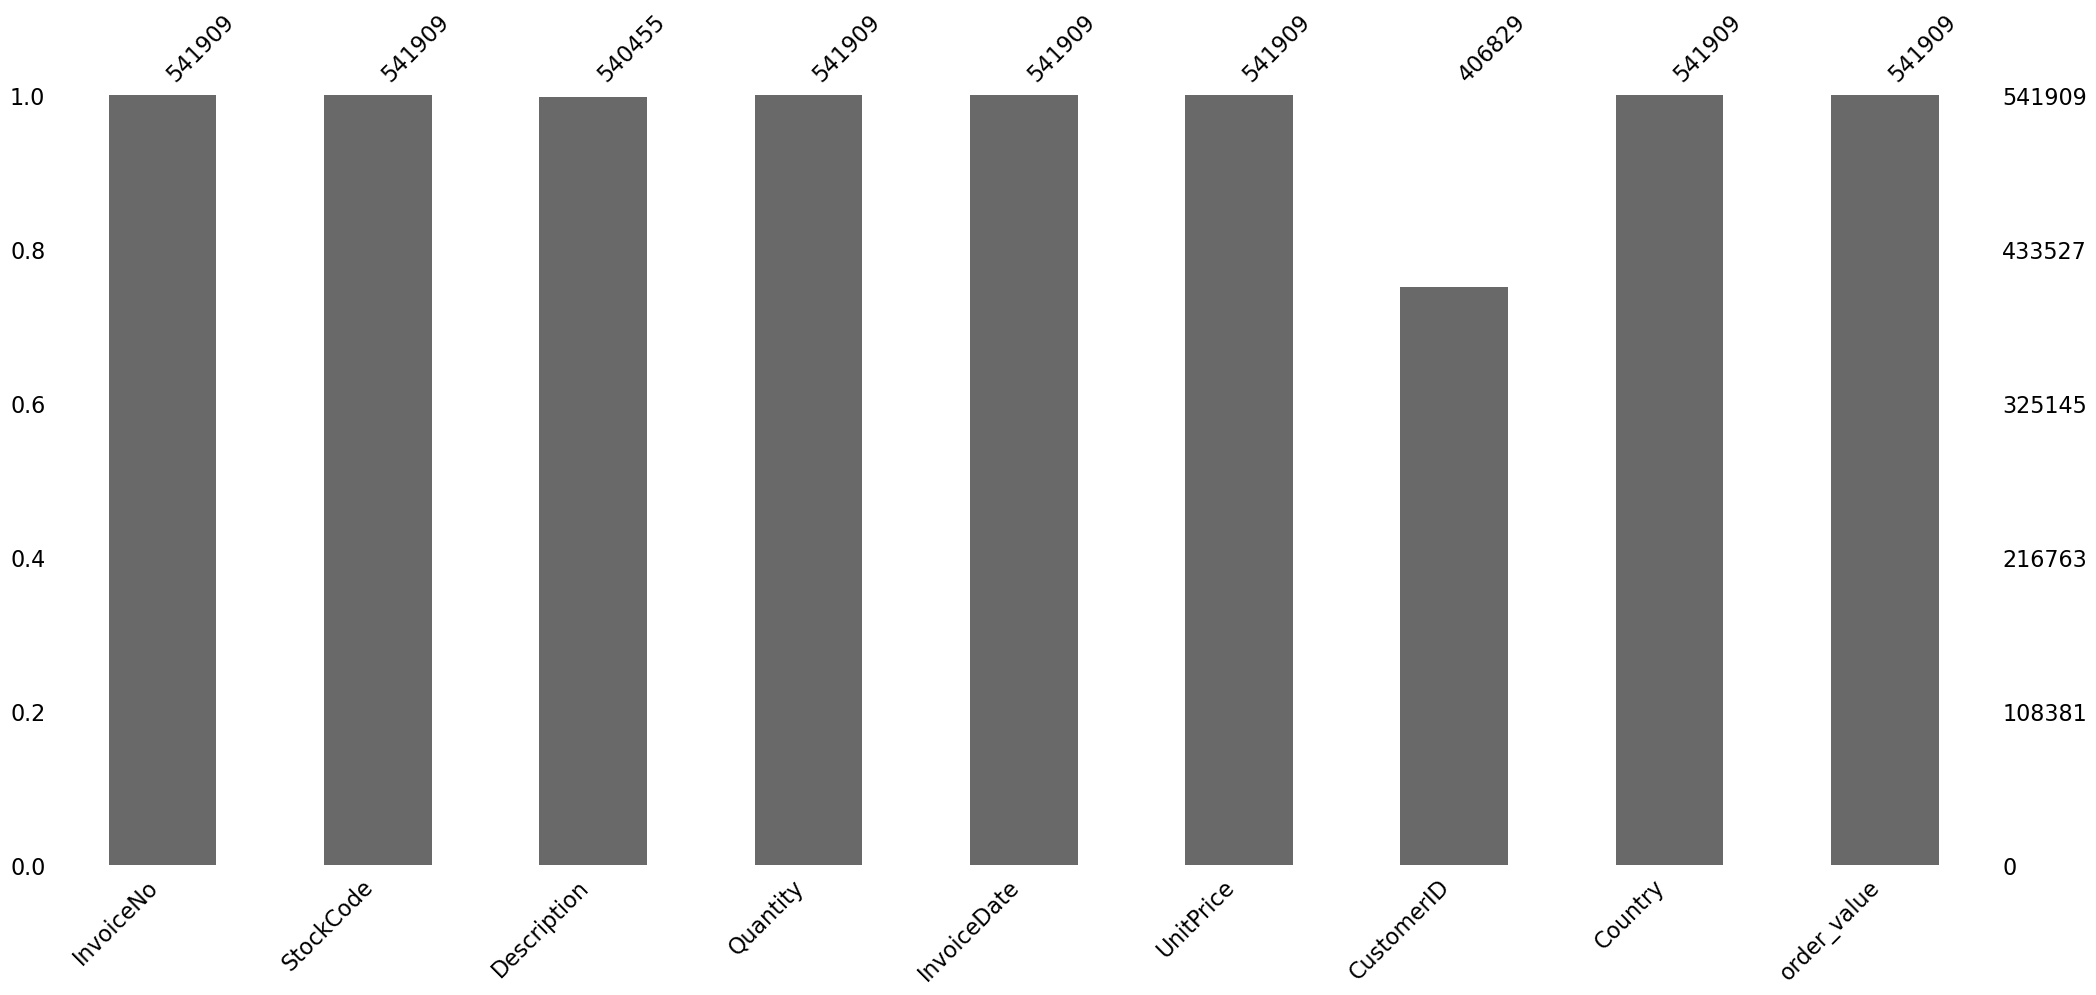

In [65]:
missingno.bar(df)
#for details: https://towardsdatascience.com/using-the-missingno-python-library-to-identify-and-visualise-missing-data-prior-to-machine-learning-34c8c5b5f009

## Cleaning Data

<AxesSubplot:>

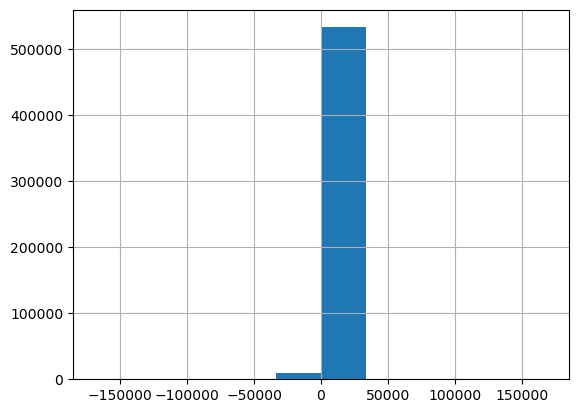

In [66]:
#Deep-dive histogram of order_value
df.order_value.hist()

<AxesSubplot:>

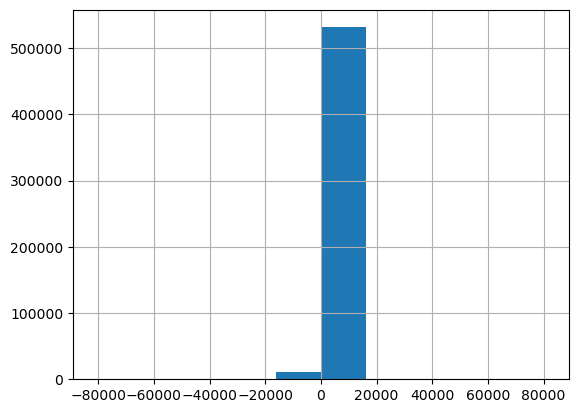

In [67]:
#Deep-dive histogram of Quantity, there's some values which is < 0 and can not view distribution clearly
df.Quantity.hist()

In [68]:
# We have some thresholds cap_90 (quanity & order_value)
quantity_cap_90 = df['Quantity'].quantile(0.95)
order_value_cap_90 = df['order_value'].quantile(0.95)

In [70]:
# TODO_04: Look at histogram by .hist() above => Determine the outliers to filter the data
quantity_cap = quantity_cap_90
order_value_cap = order_value_cap_90
order_value_flr = 0
df2 = df[(df.Quantity <= quantity_cap) & (df.order_value <= order_value_cap) & (df.order_value > order_value_flr)]
# Quantity, UnitPrice, order_value are components which can not be NaN
df2.dropna(inplace=True)
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,363958.0,6.857203,6.545413,1.000,2.00,4.00,12.00,29.00
UnitPrice,363958.0,2.866273,3.080768,0.001,1.25,1.95,3.75,57.95
order_value,363958.0,12.371180,10.110369,0.001,4.20,10.20,17.40,59.40


In [76]:
# type(df.InvoiceDate[0])
# df.Quantity[541904] => extract value in Quantity column with the 541904th values
# df.InvoiceDate[0] => the first value in InvoiceDate column

12

In [61]:
def lambda_func(x:dt.datetime) -> str:
    return x.strftime('%Y-%m')

In [142]:
# def cap_percentile(x: pd.Series, p_cap: float) -> pd.Series:
#     return x[x<= x.quantile(quantity_cap)]
# df.apply(lambda x: cap_percentile(x,order_value_cap=0.95), axis = 1)
# df.select_dtypes('float').apply(lambda x: cap_percentile(x,p_cap=0.95),axis = 1)

## Prepare the Data for Cohort Analysis

### Step 1. `invoice_period`

Generate the invoice_period by extracting Year-Month of InvoiceDate. By this, we change the frequency from Daily to Monthly.

In [77]:
df2['invoice_period'] = df['InvoiceDate'].apply(lambda x: x.strftime('%Y-%m'))
df2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_value,invoice_period
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12


### Step 2. `cohort_group`

- Set index to `CustomerID`
- `groupby(level=0)` which is equivalent to groupby `CustomerID`
- Remember the reset the index

> Discussion: What happend if we do not set the index and `groupby(level=0)`? Hint: Try to run `groupby('CustomerID')` directly?

In [78]:
# groupby will return the series with length shorter the the original, by the trick of set index, it enables us to group by, keep the original length
df2.set_index('CustomerID', inplace=True) 
df2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,order_value,invoice_period
CustomerID,,,,,,,,,
17850,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,15.30,2010-12
17850,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,20.34,2010-12
17850,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,22.00,2010-12
17850,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,20.34,2010-12
17850,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,20.34,2010-12


In [87]:
# TODO_05: From the code below, how the cohort_group is defined?
# df2['cohort_group'] = df2.groupby(level=0)['InvoiceDate'].min().apply(lambda x: x.strftime('%Y-%m'))
df2['cohort_group'] = df2.groupby(level=0)['InvoiceDate'].min().apply(lambda x: x.strftime('%Y-%m'))
df2.head(100) 

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,order_value,invoice_period,cohort_group
CustomerID,,,,,,,,,,
17850,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,15.30,2010-12,2010-12
17850,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,20.34,2010-12,2010-12
17850,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,22.00,2010-12,2010-12
17850,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,20.34,2010-12,2010-12
17850,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,20.34,2010-12,2010-12
...,...,...,...,...,...,...,...,...,...,...
15311,536381,21672,WHITE SPOT RED CERAMIC DRAWER KNOB,6,2010-12-01 09:41:00,1.25,United Kingdom,7.50,2010-12,2010-12
15311,536381,22774,RED DRAWER KNOB ACRYLIC EDWARDIAN,24,2010-12-01 09:41:00,1.25,United Kingdom,30.00,2010-12,2010-12
15311,536381,22771,CLEAR DRAWER KNOB ACRYLIC EDWARDIAN,24,2010-12-01 09:41:00,1.25,United Kingdom,30.00,2010-12,2010-12


In [88]:
df2.reset_index(inplace=True)
df2.head()

,CustomerID,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,order_value,invoice_period,cohort_group
0,17850,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,15.30,2010-12,2010-12
1,17850,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,20.34,2010-12,2010-12
2,17850,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,22.00,2010-12,2010-12
3,17850,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,20.34,2010-12,2010-12
4,17850,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,20.34,2010-12,2010-12


### Step 3. Aggregate Metrics

In [89]:
# TODO_06: 
# Later, we want to visualize the activities of customers (in terms of quantity & value) 
# month-over-month and split by cohorts
# WHAT we should pass on groupby?

g = df2.groupby(['cohort_group','invoice_period'])
cohorts = g.agg({
    'CustomerID': pd.Series.nunique,
    'Description': pd.Series.nunique,
    'Quantity': np.sum,
    'order_value': np.sum
})
cohorts.rename(columns={
    'CustomerID':'cust_cnt',
    'Description':'product_item_cnt',
    'Quantity':'total_quant',
    'order_value':'total_value'
}, inplace=True)
cohorts.head()

cust_cnt  product_item_cnt  total_quant  \
cohort_group invoice_period                                            
2010-12      2010-12              829              2368       147428   
             2011-01              298              1709        65845   
             2011-02              254              1617        50311   
             2011-03              306              1787        65749   
             2011-04              292              1731        59234   

                             total_value  
cohort_group invoice_period               
2010-12      2010-12           292102.91  
             2011-01           117929.78  
             2011-02            91626.02  
             2011-03           117187.14  
             2011-04           103408.53

### Step 4. `cohort_period`

We want to count the transaction month relative from cohort_date (ie. 1, 2, 3 month after the date of acquired - cohort_date)

In [90]:
def cohort_period(df):
  df['cohort_period'] = np.arange(len(df)) + 1
  return df

In [91]:
cohorts = cohorts.groupby(level=0).apply(cohort_period) # level 0: cohort_group, apply for each row (invoice_periods)
cohorts.head(40)

cust_cnt  product_item_cnt  total_quant  \
cohort_group invoice_period                                            
2010-12      2010-12              829              2368       147428   
             2011-01              298              1709        65845   
             2011-02              254              1617        50311   
             2011-03              306              1787        65749   
             2011-04              292              1731        59234   
             2011-05              325              1779        70671   
             2011-06              297              1798        63935   
             2011-07              274              1882        71207   
             2011-08              281              1863        68330   
             2011-09              311              2053        88242   
             2011-10              298              2007        80106   
             2011-11              409              2226       122205   
             2011-12              210              1675        43853   
2011-01      2011-01              398              1766        68568   
             2011-02               83               996        12871   
             2011-03              107              1075        16926   
             2011-04               88               923        13253   
             2011-05              130              1074        23626   
             2011-06              115              1105        21466   
             2011-07               99              1027        18349   
             2011-08               99              1103        20100   
             2011-09              125              1265        26993   
             2011-10              132              1431        31203   
             2011-11              148              1627        36121   
             2011-12               48               736         8286   
2011-02      2011-02              358              1723        63159   
             2011-03               59               727         8297   
             2011-04               65               915        12082   
             2011-05               97               977        18821   
             2011-06               96               915        17100   
             2011-07               88               880        14254   
             2011-08               87               911        17568   
             2011-09               94              1041        22414   
             2011-10               91              1183        19644   
             2011-11              107              1110        20819   
             2011-12               24               331         3556   
2011-03      2011-03              439              1843        78586   
             2011-04               65               741        10100   
             2011-05              108               944        18370   
             2011-06               86               969        16457   

                             total_value  cohort_period  
cohort_group invoice_period                              
2010-12      2010-12          292102.910              1  
             2011-01          117929.780              2  
             2011-02           91626.020              3  
             2011-03          117187.140              4  
             2011-04          103408.530              5  
             2011-05          133159.810              6  
             2011-06          117402.130              7  
             2011-07          116666.190              8  
             2011-08          117469.700              9  
             2011-09          155671.970             10  
             2011-10          146594.960             11  
             2011-11          222714.090             12  
             2011-12           76778.230             13  
2011-01      2011-01          125905.880              1  
             2011-02           27304.900              2  
             2011-

In [150]:
# cohorts.loc['2010-12',:]

In [92]:
cohorts.groupby(level=0).apply(lambda x: print(x))

                             cust_cnt  product_item_cnt  total_quant  \
cohort_group invoice_period                                            
2010-12      2010-12              829              2368       147428   
             2011-01              298              1709        65845   
             2011-02              254              1617        50311   
             2011-03              306              1787        65749   
             2011-04              292              1731        59234   
             2011-05              325              1779        70671   
             2011-06              297              1798        63935   
             2011-07              274              1882        71207   
             2011-08              281              1863        68330   
             2011-09              311              2053        88242   
             2011-10              298              2007        80106   
             2011-11              409              2226       12

""


In [152]:
# cohorts.loc[('2010-11','2010-12')]groupby(level=0).apply(lambda x: print(x))

In [93]:
cohorts.reset_index(inplace=True)
cohorts.set_index(['cohort_period','cohort_group'], inplace=True)
cohorts.head()

,,invoice_period,cust_cnt,product_item_cnt,total_quant,total_value
cohort_period,cohort_group,,,,,
1,2010-12,2010-12,829,2368,147428,292102.91
2,2010-12,2011-01,298,1709,65845,117929.78
3,2010-12,2011-02,254,1617,50311,91626.02
4,2010-12,2011-03,306,1787,65749,117187.14
5,2010-12,2011-04,292,1731,59234,103408.53


## Cohort Analysis

### Monthly Total Sales Across Cohorts

In [94]:
cohorts['total_value'].unstack(0)

cohort_period,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort_group,,,,,,,,,,,,,
2010-12,292102.910,117929.78,91626.02,117187.14,103408.53,133159.81,117402.13,116666.19,117469.700,155671.97,146594.96,222714.09,76778.23
2011-01,125905.880,27304.90,32484.03,24270.35,44771.55,39865.02,33324.82,34635.37,46898.561,58996.98,66760.29,13435.12,NaN
2011-02,114794.180,15539.71,21563.95,35076.76,30208.79,23709.98,30447.09,41752.46,37182.500,39423.09,7296.17,NaN,NaN
2011-03,142649.070,19518.98,35588.41,30444.85,30086.25,28636.91,42499.64,45260.40,48324.580,9264.62,NaN,NaN,NaN
2011-04,92425.771,18431.35,16561.83,17549.16,16852.72,24031.66,23466.14,26365.59,5611.980,NaN,NaN,NaN,NaN
2011-05,81077.160,12206.94,13128.47,14104.62,22318.23,26104.53,25302.55,8721.15,NaN,NaN,NaN,NaN,NaN
2011-06,66156.300,8161.62,10024.55,18874.46,19294.91,26721.20,5597.00,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,57148.941,7547.66,13740.96,15899.98,16522.41,5300.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,61765.700,15289.16,29383.18,31377.65,11838.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Monthly Total Sales Across Cohorts')

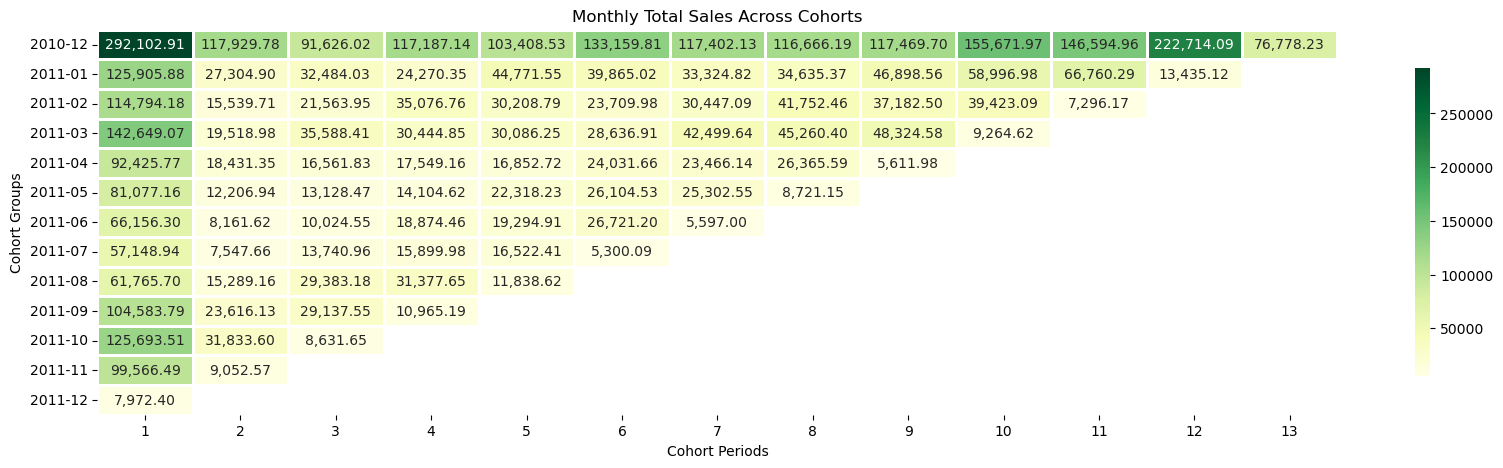

In [95]:
unstacked_value = cohorts['total_value'].unstack(0)
plt.figure(figsize=(20,5))
ax = sns.heatmap(unstacked_value, annot=True, cmap='YlGn',fmt=",.2f", 
           linewidths=1,
           cbar_kws={"shrink": .8})
ax.set_ylabel('Cohort Groups')
ax.set_xlabel('Cohort Periods')
ax.set_title('Monthly Total Sales Across Cohorts')

In [156]:
# TODO_07: Comments and highlight any insights from the charts

### Retention

> Retention of each cohort over time (periods) is the number of active users at each period, divide for the cohort size (= user count in first periods)
- Size of cohort (`denomiator`)
- Spread the `cust_cnt` - active users over periods of each cohorts
- Divide for the **retention rate**: `cust_retention.divide(cohorts_size, axis=0)`

In [96]:
cohorts

,,invoice_period,cust_cnt,product_item_cnt,total_quant,total_value
cohort_period,cohort_group,,,,,
1,2010-12,2010-12,829,2368,147428,292102.91
2,2010-12,2011-01,298,1709,65845,117929.78
3,2010-12,2011-02,254,1617,50311,91626.02
4,2010-12,2011-03,306,1787,65749,117187.14
5,2010-12,2011-04,292,1731,59234,103408.53
...,...,...,...,...,...,...
2,2011-10,2011-11,82,1283,18180,31833.60
3,2011-10,2011-12,41,566,4902,8631.65
1,2011-11,2011-11,317,2108,60511,99566.49


In [97]:
# TODO_08: With the piece of code below, how the cohorts size is defined?
cohorts_size = cohorts.groupby(level=1)['cust_cnt'].first()
cohorts_size

cohort_group
2010-12    829
2011-01    398
2011-02    358
2011-03    439
2011-04    294
2011-05    279
2011-06    239
2011-07    193
2011-08    165
2011-09    292
2011-10    355
2011-11    317
2011-12     38
Name: cust_cnt, dtype: int64

In [98]:
cust_retention = cohorts['cust_cnt'].unstack(0)
cust_retention.head()

cohort_period,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort_group,,,,,,,,,,,,,
2010-12,829.0,298.0,254.0,306.0,292.0,325.0,297.0,274.0,281.0,311.0,298.0,409.0,210.0
2011-01,398.0,83.0,107.0,88.0,130.0,115.0,99.0,99.0,125.0,132.0,148.0,48.0,NaN
2011-02,358.0,59.0,65.0,97.0,96.0,88.0,87.0,94.0,91.0,107.0,24.0,NaN,NaN
2011-03,439.0,65.0,108.0,86.0,99.0,75.0,111.0,102.0,119.0,38.0,NaN,NaN,NaN
2011-04,294.0,57.0,57.0,57.0,55.0,66.0,64.0,75.0,21.0,NaN,NaN,NaN,NaN


In [160]:
cust_retention = cust_retention.divide(cohorts_size, axis=0)
cust_retention 

cohort_period,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort_group,,,,,,,,,,,,,
2010-12,1.0,0.359469,0.306393,0.369119,0.352232,0.392039,0.358263,0.330519,0.338963,0.375151,0.359469,0.493366,0.253317
2011-01,1.0,0.208543,0.268844,0.221106,0.326633,0.288945,0.248744,0.248744,0.314070,0.331658,0.371859,0.120603,NaN
2011-02,1.0,0.164804,0.181564,0.270950,0.268156,0.245810,0.243017,0.262570,0.254190,0.298883,0.067039,NaN,NaN
2011-03,1.0,0.148064,0.246014,0.195900,0.225513,0.170843,0.252847,0.232346,0.271071,0.086560,NaN,NaN,NaN
2011-04,1.0,0.193878,0.193878,0.193878,0.187075,0.224490,0.217687,0.255102,0.071429,NaN,NaN,NaN,NaN
2011-05,1.0,0.186380,0.179211,0.164875,0.215054,0.222222,0.268817,0.093190,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.175732,0.154812,0.263598,0.225941,0.326360,0.100418,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.160622,0.217617,0.233161,0.279793,0.124352,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.193939,0.254545,0.242424,0.139394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Cohorts Monhtly Retention')

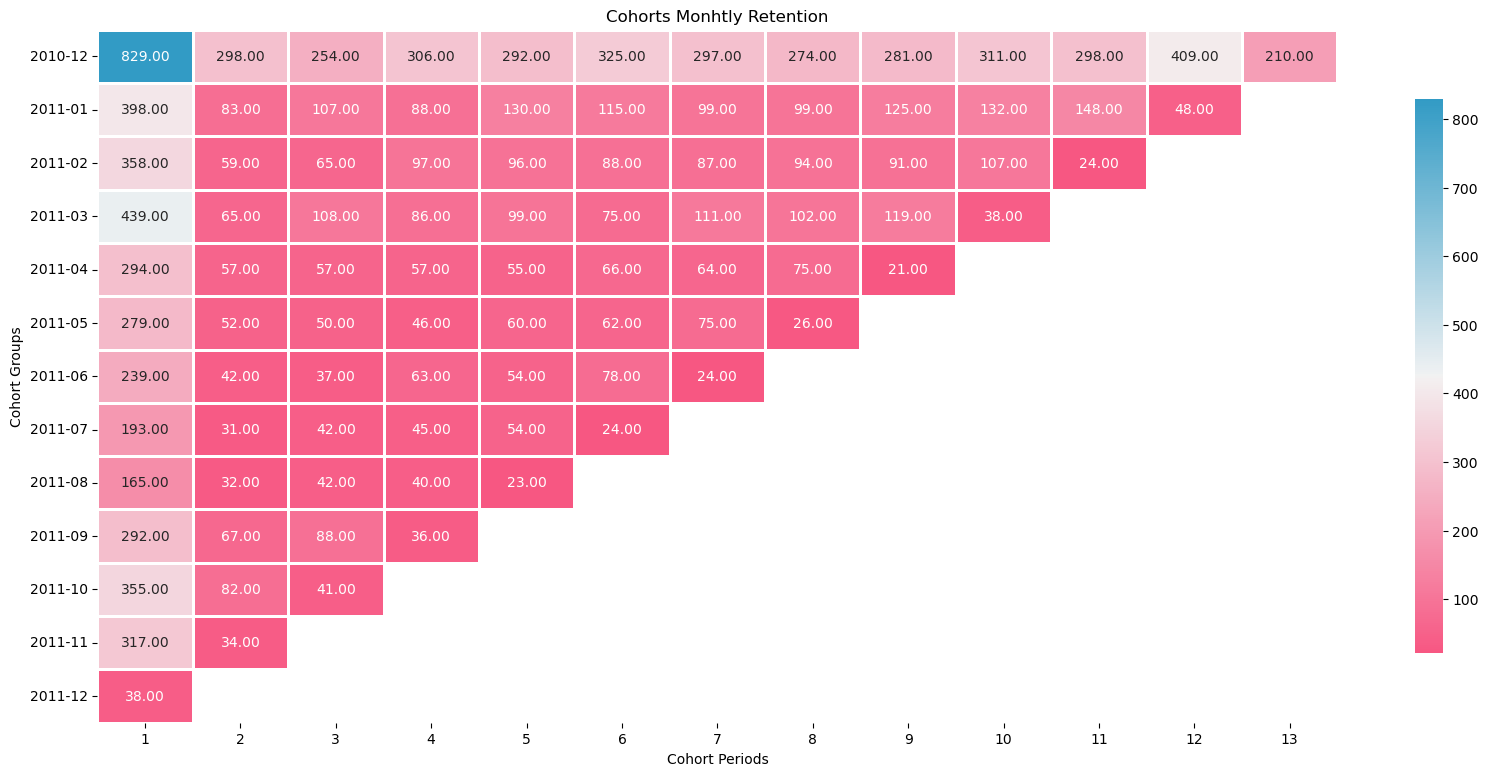

In [99]:
plt.figure(figsize=(20,9))
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
ax = sns.heatmap(cust_retention, annot=True, cmap=cmap,fmt=".2f", 
           linewidths=1,
           cbar_kws={"shrink": .8})
ax.set_ylabel('Cohort Groups')
ax.set_xlabel('Cohort Periods')
ax.set_title('Cohorts Monhtly Retention')

In [103]:
# TODO_09: Comments and highlight any insights from the charts